In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
def generate_mesh(nx, ny, buff=1, xmin=-5, xmax=5, ymin=-5, ymax=5):

    u = np.zeros((nx + 2 * buff, ny + 2 * buff))
    x = np.linspace(xmin, xmax, nx + 2 * buff)
    y = np.linspace(ymin, ymax, ny + 2 * buff)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    return u, x, y, dx, dy
   

In [3]:
@numba.jit(nopython=True)
def jacobi(u, uold, nx, ny, omega=None):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = 0.25 * (uold[i-1, j] + uold[i+1, j] + uold[i, j-1] + uold[i, j+1])
    return u

@numba.jit(nopython=True)
def GaussSeidel(u, _unused, nx, ny, omega=None):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
    return u

@numba.jit(nopython=True)
def SOR(u, uold, nx, ny, omega=1.2):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = (1 - omega) * uold[i,j] + omega * 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
    return u

def relax(u, method, tol=1e-6, maxiter=100_000, omega=1.2):
    err = np.zeros(maxiter)
    nx, ny = u.shape
    
    uold = u.copy()
    if method == 'jacobi':
        method = jacobi
    elif method == 'GaussSeidel':
        method = GaussSeidel
    elif method == 'SOR':
        method = SOR
    else:
        raise ValueError('Method not implemented')
    
    for i in range(maxiter):
        u = method(u, uold, nx, ny, omega)
        err[i] = np.linalg.norm(u - uold, np.inf)
        uold = np.copy(u)
        if err[i] < tol:
            break
    
    return u, i, err

In [4]:
def generate_rho(N=128, xmin=-5, xmax=5, ymin=-5,ymax=5):
    # TODO:
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)

    xx, yy = np.meshgrid(x, y, indexing='ij')
    r1 = (xx + 1.5)**2 + yy**2
    r2 = (xx - 1.5)**2 + yy**2
    rho = np.exp(-5 / 4 * r1**2) + 3 / 2 * np.exp(-r2**2)
    
    return xx, yy, rho


In [5]:
N = 128
u, x, y, dx, dy = generate_mesh(N, N, buff=1)

u[0, :] = 0
u[-1, :] = 0
u[:, 0] = 0
u[:, -1] = 0

xx, yy, rho = generate_rho(N)
u[1:-1, 1:-1] = rho

u_1 = np.copy(u)
u_2 = np.copy(u)
u_3 = np.copy(u)
u_4 = np.copy(u)
u_5 = np.copy(u)

u_jac, iteration_jac, err_jac = relax(u_1, 'jacobi')
u_gauss, iteration_gauss, err_gauss = relax(u_2, 'GaussSeidel')
u_sor1p2, iteration_sor1p2, err_sor1p2 = relax(u_3, 'SOR', omega=1.2)
u_sor1p5, iteration_sor1p5, err_sor1p5 = relax(u_4, 'SOR', omega=1.5)
u_sor2p0, iteration_sor2p0, err_sor2p0 = relax(u_5, 'SOR', omega=2.0)



In [6]:
print(f'Jacobi: {iteration_jac} iterations')
print(f'Gauss-Seidel: {iteration_gauss} iterations')
print(f'SOR (omega=1.2): {iteration_sor1p2} iterations')
print(f'SOR (omega=1.5): {iteration_sor1p5} iterations')
print(f'SOR (omega=2.0): {iteration_sor2p0} iterations')

Jacobi: 29030 iterations
Gauss-Seidel: 15689 iterations
SOR (omega=1.2): 10915 iterations
SOR (omega=1.5): 5845 iterations
SOR (omega=2.0): 99999 iterations


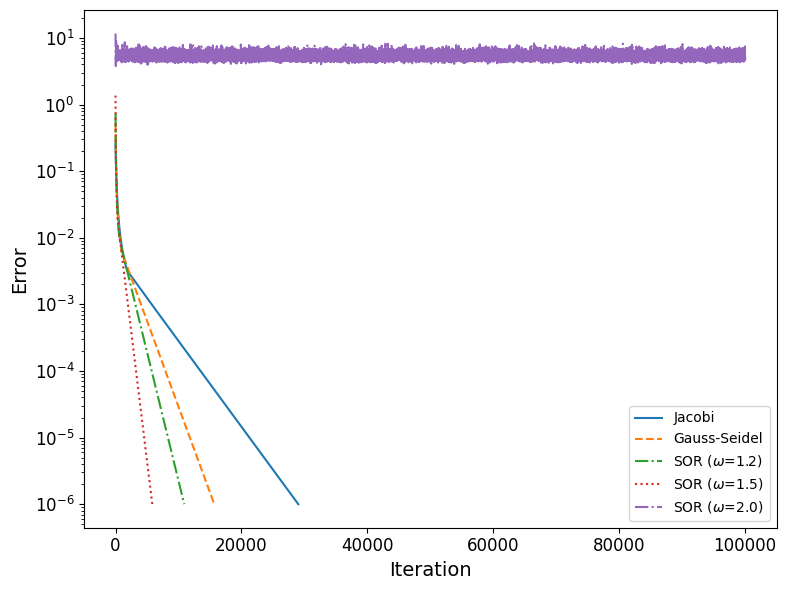

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(err_jac[:iteration_jac], label='Jacobi')
plt.plot(err_gauss[:iteration_gauss], label='Gauss-Seidel', linestyle='--')
plt.plot(err_sor1p2[:iteration_sor1p2], label=r'SOR ($\omega$=1.2)', linestyle='-.')
plt.plot(err_sor1p5[:iteration_sor1p5], label=r'SOR ($\omega$=1.5)', linestyle=':')
plt.plot(err_sor2p0[:iteration_sor2p0], label=r'SOR ($\omega$=2.0)', linestyle='-.')
# plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.tight_layout()
plt.savefig('error.png')
plt.show()
